In [344]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import linalg

\begin{align*}
    Q(f)
    :=
    \frac{1}{2 \pi i}
    \int_{|\lambda| = R}
    f(\lambda)
    d \lambda
\end{align*}

\begin{align*}
    Q_m(f)
    :=
    \frac{R}{m}
    \sum_{\nu=0}^{m-1}
    \omega_m^\nu f(R \omega_m^\nu),
    \quad
    \omega_m
    :=
    \exp
    \left(
        \frac{2 \pi i}{m}
    \right )
\end{align*}

In [345]:
omega = lambda m: np.exp(2 * np.pi * 1j / m)

Q_zero = lambda m, f, R: R / m * sum([
    omega(m) ** nu * f(R * omega(m) ** nu)
    for nu in range(m)
])

Q = lambda m, f, R, z: Q_zero(
    m,
    lambda x: f(x - z),
    R
)

In [346]:
def plot_complex(numbers, approx_numbers = None, title = None):

    fig = plt.figure(figsize = (8, 8))

    plt.scatter(
        *np.array([
            [number.real, number.imag]
            for number in numbers
        ]).transpose(), edgecolors = "blue"
    )
    
    if approx_numbers:
        plt.scatter(
            *np.array([
                [number.real, number.imag]
                for number in approx_numbers
            ]).transpose(), edgecolors = "red"
        )

    plt.grid(linestyle = ':')
    plt.xlabel('$\Re$')
    plt.ylabel('$\Im$')

    if title != None:
        plt.suptitle(title)

    fig.show()

<ipython-input-346-bacad595a497>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


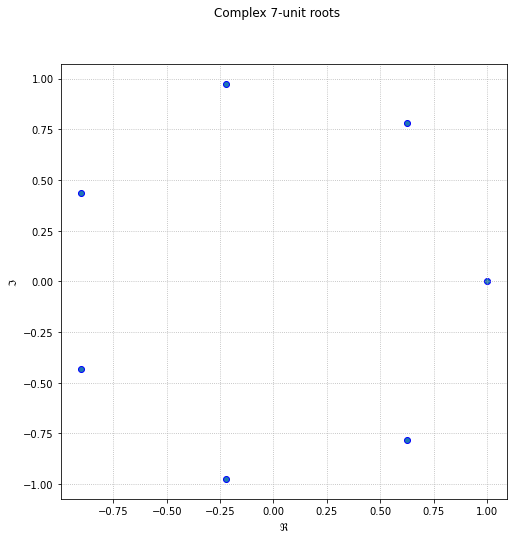

In [347]:
m = 7

numbers = [
    omega(m) ** nu
    for nu in range(m)
]

title = f'Complex {m}-unit roots'

plot_complex(numbers, None, title)

\begin{align*}
    A_0
    & :=
    \frac{1}{2 \pi i}
    \int_\Gamma
    A(\lambda)^{-1} \hat{V}
    d \lambda
    \in \mathbb{C}^{N \times j}, \\
    A_1
    & :=
    \frac{1}{2 \pi i}
    \int_\Gamma
    \lambda A(\lambda)^{-1} \hat{V}
    d \lambda
    \in \mathbb{C}^{N \times j}
\end{align*}

1. Berechne $A_0 \in \mathbb{C}^{N \times j}$

2. Berechne reduzierte Singulärwertzerlegung $A_0 = \tilde{V} \Sigma \tilde{W}^\ast$ mit $J$ Singulärwerten

3. Berechne $A_1 \in \mathbb{C}^{N \times j}$

4. Berechne die Eigenwerte der Matrix $\tilde{V} A_1 \tilde{W} \Sigma^{-1} \in \mathbb{C}^{j \times j}$ (z.B. mit QR-Verfahren)

In [348]:
omega = lambda m: np.exp(2 * np.pi * 1j / m)

Q_zero = lambda m, f, R: R / m * sum([
    omega(m) ** nu * f(R * omega(m) ** nu)
    for nu in range(m)
])

Q = lambda m, f, R, z: Q_zero(
    m,
    lambda x: f(x + z),
    R
)

def integral_method(A, N, j, m, R, z, tol):

    """
    A ... matrix-function
    N ... number of rows/columns of A(lambda)
    j ... number of expected eigen values in B_R(z)
    m ... number of quadrature-nodes
    R ... ball-radius
    z ... ball-center
    """


    # random matrix
    V_hat = np.random.random((N, j))

    # ------------------------ #
    # step 1

    # integrand of A_0
    def f_0(lamda):

        LU, piv = linalg.lu_factor(A(lamda))
        return np.array([
            linalg.lu_solve((LU,piv), V_hat[:, i])
            for i in range(j)
        ]).T
    A_0 = Q(m, f_0, R, z)

    # ------------------------ #
    # step 2

    V_tilde, Sigma, W_tilde = linalg.svd(A_0, full_matrices = False)

    mask = np.abs(Sigma) > tol

    Sigma = Sigma[mask]
    V_tilde = V_tilde[:,mask]
    W_tilde = W_tilde[mask,:]
        

    # ------------------------ #
    # step 3

    # integrand of A_1
    f_1 = lambda lamda: lamda * f_0(lamda)
    A_1 = Q(m, f_1, R, z)

    # ------------------------ #
    # step 4
    return linalg.eigvals(V_tilde.conj().T @ A_1 @ W_tilde.conj().T @ np.diag(Sigma ** -1))

# Testing

Um die Funktion `integral_method` zu testen, konstruieren wir einfache Matrix-Funktionen.

Die wohl einfachsten Matrix-Funktion sind konstant gleich einer Matrix.
Die Eigenwerte von Diagonalmatrizen stehen direkt in ihrer Diagonale.
Ähnliche Matrizen haben dieselben Eigenwerte.

Wir werden also für gegebene Eigenwerte `eigen_values` eine Diagonalmatrix `diagonal_matrix` erstellen und diese mit irgendeiner regulären Matrix `T` bzw. ihrer Inversen `T.inv()` von links und rechts multiplizieren.
Die dadurch entstandene Matrix `A_const` hat also die Eigenwerte `eigen_values`.
Jetzt müssen wir `A_const` nur noch zu einer konstanten Funktion `A` machen.

<ipython-input-346-bacad595a497>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


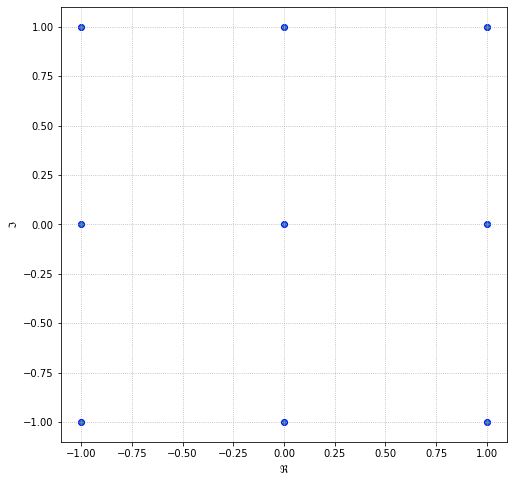

In [349]:
eigen_values = [1 + 1j, 1 - 1j, -1 + 1j, -1 - 1j, 0, 1, 1j, -1j, -1]
N = len(eigen_values)

plot_complex(eigen_values)

In [350]:
# diagonal matrix with eigen values in diagonal
diagonal_matrix = np.diag(eigen_values)

# transformation matrix
T = np.random.random(diagonal_matrix.shape)

# arbitrary matrix with known eigen values
A = T @ diagonal_matrix @ linalg.inv(T)
# function A
A = lambda lamda: T @ diagonal_matrix @ linalg.inv(T) - lamda*np.eye(N)


In [351]:
# confirmation
vals, vectors = linalg.eig(A_const)
vals

array([ 1.+1.j,  1.-1.j, -1.+1.j, -1.-1.j])

0.46433306364135796
0.5330043484490185
0.5923684632674527
0.5830944117034342
0.3552544863269797
0.004747515101230229
4.994840622845512e-07
3.3309057742653945e-12
7.733402703665958e-15


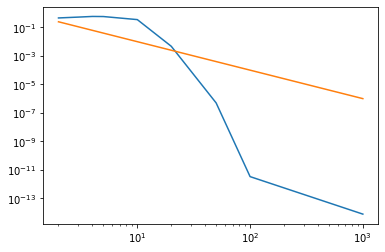

In [381]:
m_array = np.array([2,3,4,5,10,20,50,100,1000])
error_array = []

for m in m_array:
    R = 1.5
    j = 4
    z = 1+1j
    tol = 1e-6

    approx_eigen_values = integral_method(A, N, j, m, R, z, tol)
    #plot_complex(eigen_values, [eig for eig in approx_eigen_values])
    max_error = max([min([np.abs(approx - eig) for eig in eigen_values]) for approx in approx_eigen_values])
    print(max_error)
    error_array.append(max_error)
    
plt.loglog(m_array,error_array)
plt.loglog(m_array,1/m_array**2)